In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.coordinates import SkyCoord, Distance
import astropy.units as un
from astropy.coordinates import Angle, Latitude, Longitude

In [14]:
#Note: this is from the nasa archive, and not our calculated final proper motion corrections!
archive=pd.read_csv("NASA_exoplanet_archive_with_proper_motion.csv",sep=',',header=47,low_memory=False)
total_pm = archive["sy_pm"].astype(float)

negligible_pm = archive.drop(archive[archive["sy_pm"] > 100].index)
print(len(negligible_pm['hostname'].unique()))
print(len(negligible_pm['pl_name'].unique()))

significant_pm = archive.drop(archive[archive["sy_pm"] < 100].index)
print(len(significant_pm['hostname'].unique()))
print(len(significant_pm['pl_name'].unique()))

print(len(archive['hostname'].unique()))
print(len(archive['pl_name'].unique()))

3489
4586
926
1278
4175
5612


i.e. of the 5612 planets and 4175 exoplanetary systems in the NASA archive, 
- 3489 systems have negligible (< 100 mas/yr) proper motion magnitudes
- 926 systems have signigicant (> 100 mas/yr) proper motion magnitudes

Now some draft histograms of the calculated proper motion corrections:

In [4]:
HAT_P_20b = pd.read_csv('HAT-P-20b_proper_corrected_NASA.csv')
ra = HAT_P_20b['ra']
dec = HAT_P_20b['dec']
ra_corrected = HAT_P_20b['ra_corrected']
dec_corrected = HAT_P_20b['dec_corrected']

ra_correction = (ra - ra_corrected).abs() 
dec_correction = (dec - dec_corrected).abs()

ra_av = ra_correction.mean()
dec_av = dec_correction.mean()

print(ra_av)
print(dec_av)

1.0297322287198771e-05
0.0001811153517522436


In [39]:
#Not using astropy, just in degrees. 
def averages(files):
    all_averages = []
    for file in files: 
        df = pd.read_csv(file)
        ra = df['ra']
        dec = df['dec']
        ra_corrected = df['ra_corrected']
        dec_corrected = df['dec_corrected']
        ra_correction = (ra - ra_corrected).abs() 
        dec_correction = (dec - dec_corrected).abs()
        ra_av = ra_correction.mean()
        dec_av = dec_correction.mean()
        all_averages.append((ra_av, dec_av))

    return all_averages 


files=glob.glob('*proper_corrected_NASA*.csv')
av = averages(files)
print(av)



[(1.0297322287198771e-05, 0.0001811153517522436), (6.721281073418033e-06, 0.00047092821931842146), (2.1941935409708325e-05, 0.0004990361506148157), (0.0006626873566293539, 0.00013459538975297148), (0.00025540677118449334, 0.00027129294411392584), (0.0009231323736621908, 0.00012175459593716802), (0.00010555067314348298, 3.579743893612842e-06), (8.62988333780038e-05, 9.816740572978597e-05), (9.529614761460591e-05, 4.476871215506658e-05), (8.02999692606234e-05, 7.187900294560759e-05)]


In [72]:
#Using astropy coordinates to convert back to arcseconds 
#BUT NEED TO DOUBLE CHECK IF SEPARATION IS ACTUALLY CALCULATING THE DIFFERENCE BETWEEN THE ANGLES!!!!!!! or if it should be another method 
def averages(files):
    all_averages = []
    for file in files: 
        df = pd.read_csv(file)
        coords = SkyCoord(ra = df['ra'] * un.deg, dec = df['dec'] * un.deg, unit = 'deg')
        corrected_coords = SkyCoord(ra = df['ra_corrected'] * un.deg, dec = df['dec_corrected'] * un.deg, unit = 'deg')
        #correction = (coords - corrected_coords).abs()
        correction = coords.separation(corrected_coords)
        #average = correction.mean()
        #correction_arcsec = correction.arcsecond
        average = correction.mean()
        average_arcsec = average.arcsecond
        all_averages.append(average_arcsec)

    return all_averages 


files=glob.glob('*proper_corrected_NASA*.csv')
av_correction = averages(files)
print(av_correction)



[0.6528895435577724, 1.695488519803327, 1.7980968756264, 1.4570557700079003, 1.3317623154752298, 3.200367889260807, 0.3027176746864983, 0.45275899405158726, 0.37860284896038654, 0.38484020440727373]


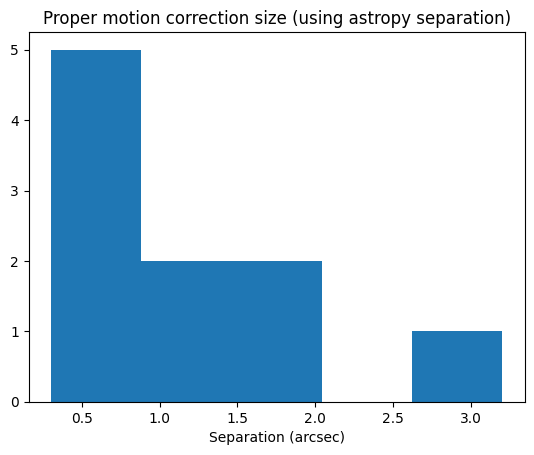

In [76]:
#Histogram using separation calculations as above:
plt.hist(av_correction, bins = 5)
plt.title('Proper motion correction size (using astropy separation)')
plt.xlabel('Separation (arcsec)')
plt.show()

In [86]:
#Instead using astropy OFFSET method - calculating difference between two angles:
#POSITIONAL_ANGLE or SPHERICAL_OFFSET_BY ?
def averages(files):
    all_averages = []
    for file in files: 
        df = pd.read_csv(file)
        coords = SkyCoord(ra = df['ra'] * un.deg, dec = df['dec'] * un.deg, unit = 'deg')
        corrected_coords = SkyCoord(ra = df['ra_corrected'] * un.deg, dec = df['dec_corrected'] * un.deg, unit = 'deg')
        #correction = (coords - corrected_coords).abs()
        ra_correction, dec_correction = coords.spherical_offsets_to(corrected_coords)
        #average = correction.mean()
        #correction_arcsec = correction.arcsecond
        ra_average = ra_correction.mean()
        dec_average = dec_correction.mean()
        ra_average_arcsec = abs(ra_average.arcsecond)
        dec_average_arcsec = abs(dec_average.arcsecond)
        all_averages.append([ra_average_arcsec, dec_average_arcsec])

    return all_averages 


files=glob.glob('*proper_corrected_NASA*.csv')
av_correction = averages(files)
print(av_correction)

[[0.033774810261088646, 0.6519831173709586], [0.02231968317975423, 1.6952580001484332], [0.0750418814609703, 1.796441559506376], [1.3740583526937349, 0.4845263823727152], [0.9053480550510402, 0.9766068167548426], [3.170052854617834, 0.4383030362901892], [0.3024283362770897, 0.012886264277018045], [0.28300053392947566, 0.35338532909328146], [0.3425691460967004, 0.16115943333133287], [0.2848419611518336, 0.25875168816726923]]


[0.033774810261088646, 0.02231968317975423, 0.0750418814609703, 1.3740583526937349, 0.9053480550510402, 3.170052854617834, 0.3024283362770897, 0.28300053392947566, 0.3425691460967004, 0.2848419611518336]
[0.6519831173709586, 1.6952580001484332, 1.796441559506376, 0.4845263823727152, 0.9766068167548426, 0.4383030362901892, 0.012886264277018045, 0.35338532909328146, 0.16115943333133287, 0.25875168816726923]


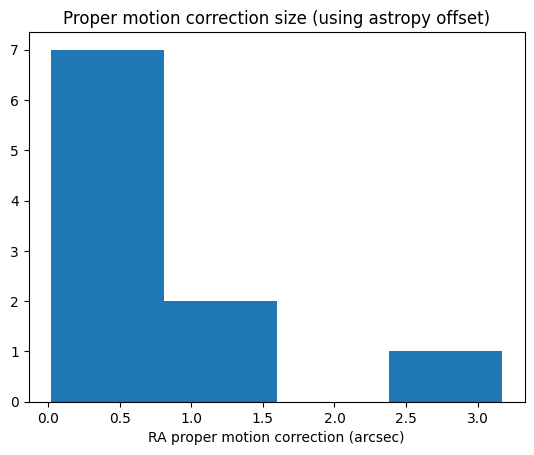

In [100]:
#av_correction_string = av_correction.to_string()
av_correction_array = np.array(av_correction).astype(float)
array_ra = [x[0] for x in av_correction_array]
array_dec = [x[1] for x in av_correction_array]

print(array_ra)
print(array_dec)

plt.hist(array_ra, bins = 4)
plt.title('Proper motion correction size (using astropy offset)')
plt.xlabel('RA proper motion correction (arcsec)')
plt.show()

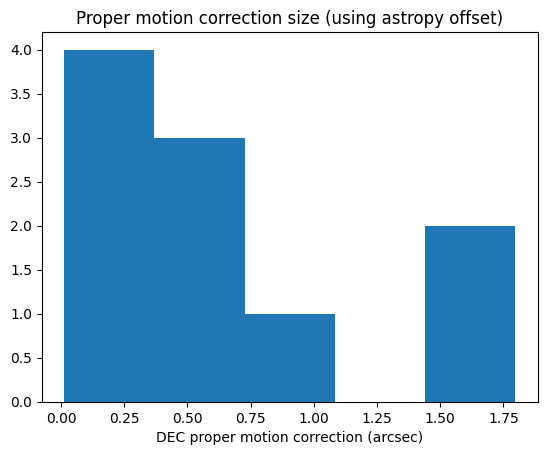

In [101]:
plt.hist(array_dec, bins = 5)
plt.title('Proper motion correction size (using astropy offset)')
plt.xlabel('DEC proper motion correction (arcsec)')
plt.show()

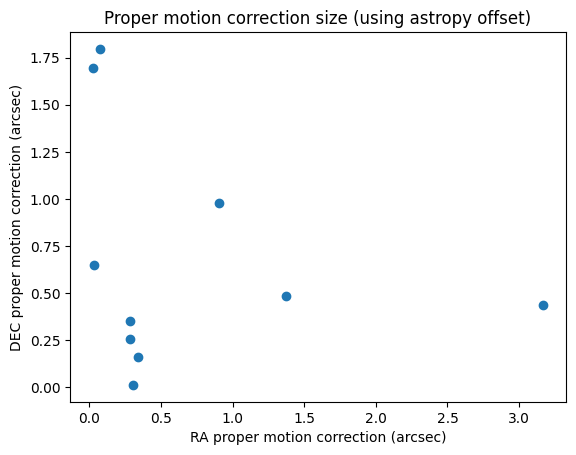

In [102]:
plt.scatter(array_ra, array_dec)
plt.title('Proper motion correction size (using astropy offset)')
plt.xlabel('RA proper motion correction (arcsec)')
plt.ylabel('DEC proper motion correction (arcsec)')
plt.show()

To check if separation is the correct method to find difference:
https://docs.astropy.org/en/stable/coordinates/matchsep.html 

NOT USING ASTROPY COORDINATES BUT JUST NUMPY SUBTRACTION OF TWO ARRAYS

[1.0297322287198771e-05, 6.721281073418033e-06, 2.1941935409708325e-05, 0.0006626873566293539, 0.00025540677118449334, 0.0009231323736621908, 0.00010555067314348298, 8.62988333780038e-05, 9.529614761460591e-05, 8.02999692606234e-05]


Text(0.5, 1.0, 'Magnitude of RA proper motion correction')

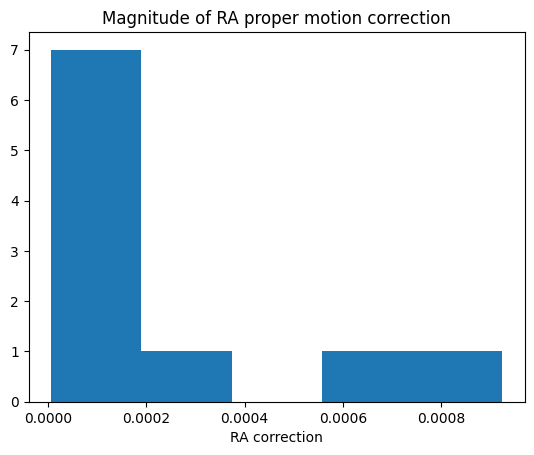

In [52]:
def ra_averages(files):
    all_ra_averages = []
    for file in files: 
        df = pd.read_csv(file)
        ra = df['ra']
        ra_corrected = df['ra_corrected']
        ra_correction = (ra - ra_corrected).abs() 
        ra_av = ra_correction.mean().astype(float)
        all_ra_averages.append(ra_av)

    return all_ra_averages 


files=glob.glob('*proper_corrected_NASA*.csv')
av_ra = ra_averages(files)
print(av_ra)

plt.hist(av_ra, bins = 5)
plt.xlabel('RA correction')
plt.title('Magnitude of RA proper motion correction')

[0.0001811153517522436, 0.00047092821931842146, 0.0004990361506148157, 0.00013459538975297148, 0.00027129294411392584, 0.00012175459593716802, 3.579743893612842e-06, 9.816740572978597e-05, 4.476871215506658e-05, 7.187900294560759e-05]


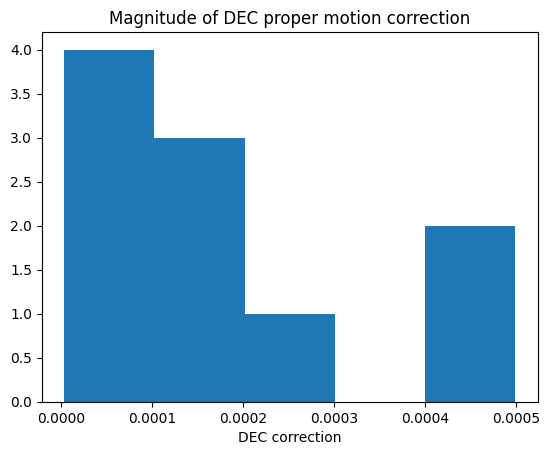

In [51]:
def dec_averages(files):
    all_dec_averages = []
    for file in files: 
        df = pd.read_csv(file)
        dec = df['dec']
        dec_corrected = df['dec_corrected']
        dec_correction = (dec - dec_corrected).abs() 
        dec_av = dec_correction.mean().astype(float)
        all_dec_averages.append(dec_av)

    return all_dec_averages 


files=glob.glob('*proper_corrected_NASA*.csv')
av_dec = dec_averages(files)
print(av_dec)

plt.hist(av_dec, bins = 5)
plt.xlabel('DEC correction')
plt.title('Magnitude of DEC proper motion correction')
plt.show()

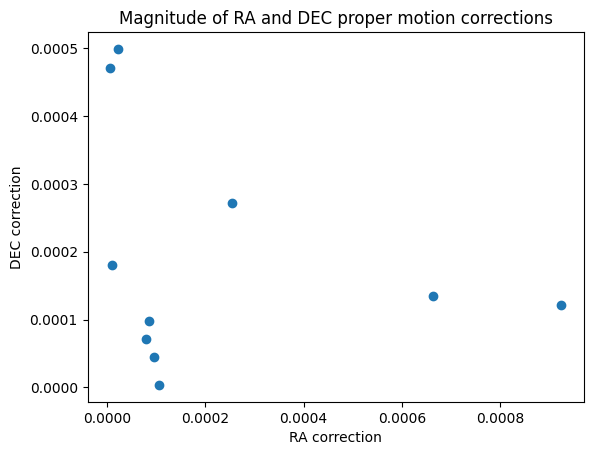

In [50]:
plt.scatter(av_ra, av_dec)
plt.title('Magnitude of RA and DEC proper motion corrections')
plt.xlabel('RA correction')
plt.ylabel('DEC correction')
plt.show()

STILL TO DO: find a way to convert the size of the correction to arcseconds/mas!!!